# Using CLIPSeg with Hugging Face Transformers

Using Hugging Face Transformers, you can easily download and run a pre-trained CLIPSeg model on your images. Let’s start by installing transformers.

In [99]:
!pip install -q transformers

To download the model, simply instantiate it.

In [100]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Now we can load an image to try out the segmentation. We'll choose a picture of a delicious breakfast taken by [Calum Lewis](https://unsplash.com/@calumlewis).

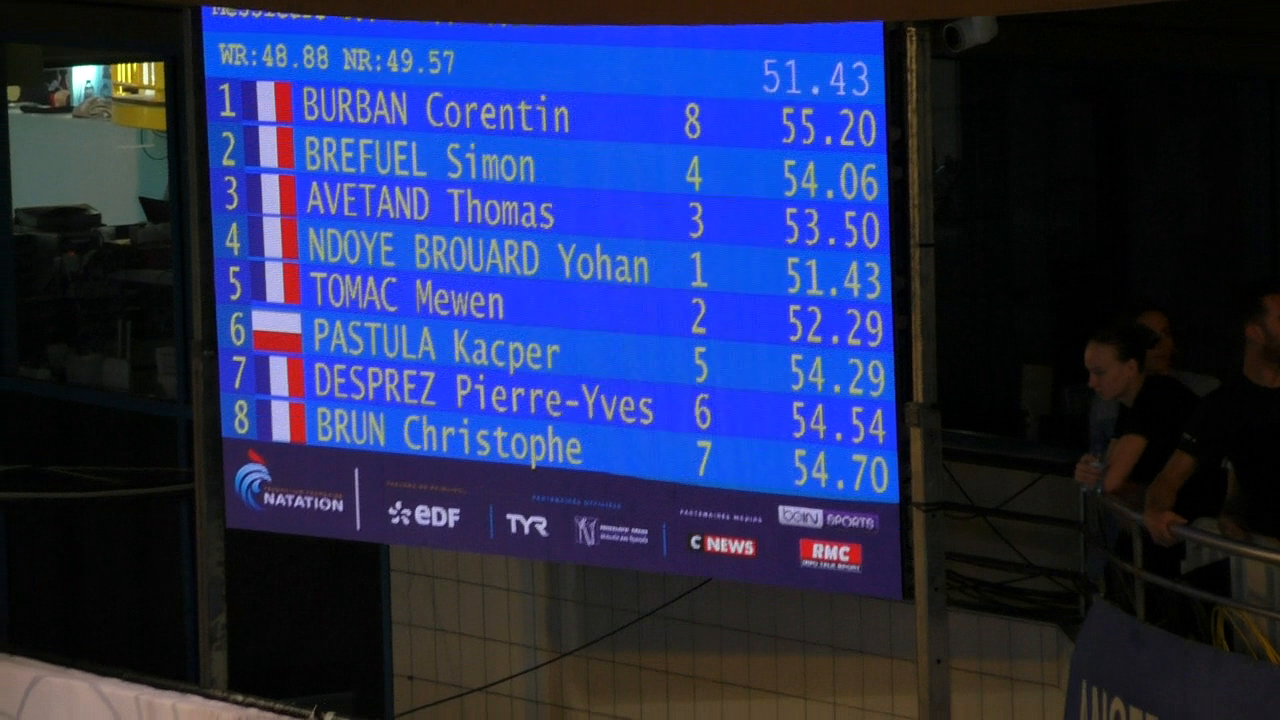

In [101]:
from PIL import Image
import requests

image = Image.open("/content/000000.png")
image

## Text prompting

Let’s start by defining some text categories we want to segment.

In [102]:
prompts = ["A swimming scoreboard is a rectangular panel that shows important information about a swimming competition. It uses bright LED lights to provide real-time updates on the progress of the race. The scoreboard is divided into several sections, each displaying different information about the race, including the name of the event, the swimmers' names, lane assignments, countries, times, and finishing order."]

Now that we have our inputs, we can process them and input them to the model.

In [103]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(0)

Finally, let’s visualize the output.

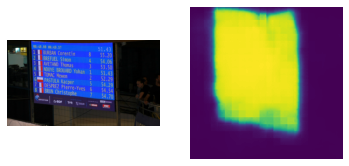

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i])) for i in range(len(prompts))];
#[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [105]:
def crop_save_image(original_image, preds, thresh=0.5):

  mask = np.array(torch.sigmoid(preds) > thresh, dtype=np.uint8)
  height, width, channels = np.array(original_image).shape

  # Resize the image
  mask = cv2.resize(mask, (width, height))

  # Find the bounding box coordinates
  x, y, w, h = cv2.boundingRect(mask)

  # Crop original image
  original_image = np.array(original_image)
  cropped_image = original_image[y:y+h, x:x+w, :]

  return cropped_image


In [106]:
from glob import glob

for path in glob("/content/[0-9]*.png"):
  image = Image.open(path)
  inputs = processor(text=prompts, images=[image], padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
  preds = outputs.logits
  # Crop image
  cropped_image = crop_save_image(image, preds, thresh=0.5)

  # Convert the image to the RGB color space
  cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  # Save the image to disk
  cv2.imwrite("text_prompt_" + path.split('/')[-1], cropped_image)

In [107]:
glob("/content/[0-9]*.png")

['/content/000007.png',
 '/content/000012.png',
 '/content/000001.png',
 '/content/000008.png',
 '/content/000013.png',
 '/content/000003.png',
 '/content/000002.png',
 '/content/000009.png',
 '/content/000014.png',
 '/content/000004.png',
 '/content/000005.png',
 '/content/000000.png',
 '/content/000011.png',
 '/content/000010.png',
 '/content/000006.png']

## Visual prompting

As mentioned before, we can also use images as the input prompts (i.e. in place of the category names). This can be especially useful if it's not easy to describe the thing you want to segment. For this example, we'll use a picture of a coffee cup taken by [Daniel Hooper](https://unsplash.com/@dan_fromyesmorecontent).

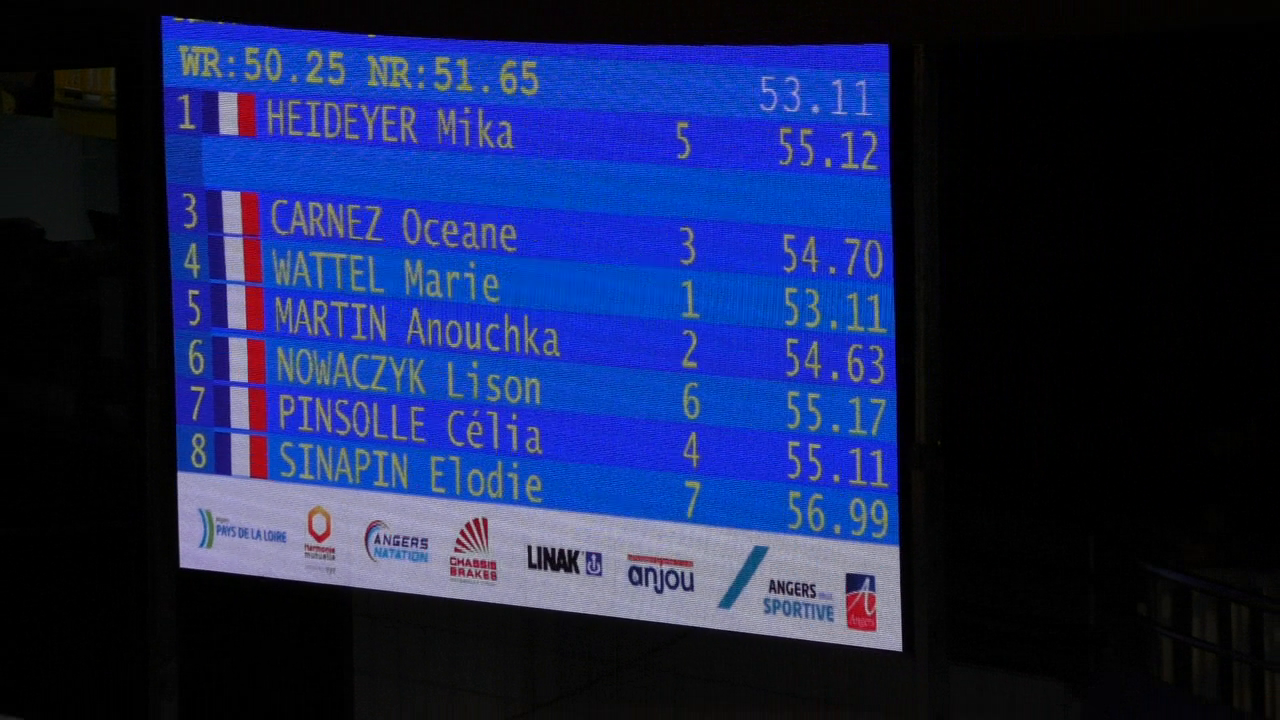

In [108]:
prompt = Image.open("/content/000003.png")
prompt

We can now process the input image and prompt image and input them to the model.

In [109]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

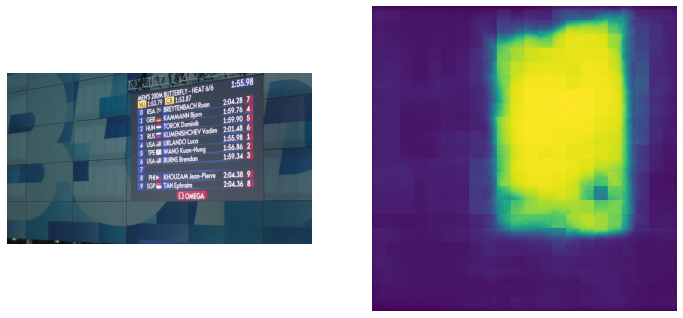

In [110]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

In [111]:
from glob import glob

for path in glob("/content/[0-9]*.png"):
  image = Image.open(path)

  encoded_image = processor(images=[image], return_tensors="pt")
  encoded_prompt = processor(images=[prompt], return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
  preds = outputs.logits.unsqueeze(1)
  preds = torch.transpose(preds, 0, 1)

  # Crop image
  cropped_image = crop_save_image(image, preds[0], thresh=0.5)

  # Convert the image to the RGB color space
  cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  # Save the image to disk
  cv2.imwrite("visual_prompt_" + path.split('/')[-1], cropped_image)